<a href="https://colab.research.google.com/github/yuliiabosher/Adam_Smith_project/blob/main/Visualisations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!pip install nltk

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import collections

nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [29]:
def month_to_number(month):
  months = {"january": "1", "february": "2", "march": "3", "april": "4", "may": "5", "june": "6", "july": "7", \
            "august": "8", "september": "9", "october": "10", "november": "11", "december": "12"}
  month = month.lower()
  numerical = months[month]
  return numerical

def to_date(string):
  elements = string.split(',')
  year = elements[-1].strip()
  month, day = elements[-2].split()
  month = month_to_number(month)
  date = f'{year}-{month}-{day}'
  return date

,Extract,Notes,Notes2,About Adam Smith,Rep
Date,,,,,
2015-12-16,"It was on this very day, December 16, 1773, th...",n/a,n/a,"-, free market economics","Kevin John Cramer,\nRepublican Party"
2017-02-02,Adam Smith is spinning in his grave as he list...,"In other words, the price to be paid to make t...",n/a,-Adam Smith is spinning in his grave as he lis...,Edward John Markey\nDemocratic Party
2017-04-27,It is enough for people to inherit a house or ...,n/a,n/a,-“: You don’t want to have inherited wealth in...,Jamie Raskin\nDemocratic Party
2017-07-13,We can’t ignore the idea that even though Adam...,n/a,n/a,-‘‘The Wealth of Nations’’\n- fundamental prin...,n/a
2017-10-03,"At the hearing today, I heard my Republican co...",So let’s pay attention here. Adam Smith said t...,n/a,"-, ‘‘The Wealth of Nations,\n- “Maintain the s...",n/a
2017-10-10,These early settlers were driven by religious ...,n/a,n/a,-capitalism. \n-The name of it is ‘‘The Wealth...,n/a
2017-11-27,You have consistently stressed that the object...,n/a,n/a,n/a,n/a
2018-03-13,"Mr. ARRINGTON. Mr. Speaker, the year 1776 mark...",n/a,n/a,-‘‘The Wealth of Nations’’\n- free markets and...,n/a
2018-04-11,The first one I would like to point out becaus...,n/a,n/a,"-‘‘The Wealth of Nations,’’\n- invisible hand\...",n/a


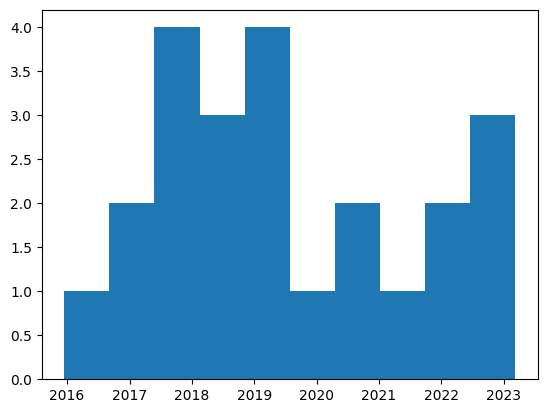

In [30]:
df = pd.read_excel('https://github.com/yuliiabosher/Adam_Smith_project/raw/main/adam_smith.xlsx', skiprows=1)
df = df.fillna('n/a')
df = df.drop(df[df['Mention of Adam smith'].str.contains('NA')].index)
df = df.drop(df[df['Mention of Adam smith'].str.contains('n/a')].index)
df.columns = ['Date', 'Extract', 'Notes', 'Notes2', 'About Adam Smith', 'Rep']
dates = []
for index, row in df.iterrows():
  dates.append(to_date(row['Date']))
df['Date'] = dates
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date').sort_index()
plt.hist(df.index)
df

In [44]:
def tokenize_df(df):
  tokens = []
  for index, row in df.iterrows():
    tokens.extend(nltk.word_tokenize(row['Extract']))
  return tokens

token_list = tokenize_df(df)
display(token_list)

['It',
 'was',
 'on',
 'this',
 'very',
 'day',
 ',',
 'December',
 '16',
 ',',
 '1773',
 ',',
 'that',
 'patriots',
 'at',
 'Boston',
 'Harbor',
 'expressed',
 'their',
 'displeasure',
 'with',
 'a',
 'foreign',
 'power',
 '’',
 's',
 'influence',
 'over',
 'what',
 'they',
 'felt',
 'was',
 'an',
 'essential',
 'commodity',
 '.',
 'Participants',
 'of',
 'the',
 'Boston',
 'Tea',
 'Party',
 ',',
 'many',
 'of',
 'whom',
 'were',
 'small-business',
 'owners',
 ',',
 'well',
 'versed',
 'in',
 'and',
 'practitioners',
 'of',
 'the',
 'teachings',
 'of',
 'Adam',
 'Smith',
 'and',
 ',',
 'yes',
 ',',
 'free',
 'market',
 'economics',
 ',',
 'never',
 'would',
 'have',
 'envisioned',
 'that',
 'one',
 'commodity',
 'should',
 'be',
 'arbitrarily',
 'discriminated',
 'against',
 'over',
 'another',
 ',',
 'especially',
 'by',
 'their',
 'own',
 'government',
 '.',
 'We',
 'have',
 'an',
 'opportunity',
 'with',
 'this',
 'commodity',
 'to',
 'make',
 'a',
 'difference',
 '.',
 'Adam',
 'S

In [57]:
def preprocess_tokens(list_of_tokens):
  lower_tokens = [t.lower() for t in list_of_tokens]
  alpha_only = [t for t in lower_tokens if t.isalpha()]
  no_stops = [t for t in alpha_only if t not in nltk.corpus.stopwords.words('english')]
  wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
  lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in no_stops]
  return lemmatized
preprocessed = preprocess_tokens(token_list)
display(preprocessed)

['day',
 'december',
 'patriot',
 'boston',
 'harbor',
 'expressed',
 'displeasure',
 'foreign',
 'power',
 'influence',
 'felt',
 'essential',
 'commodity',
 'participant',
 'boston',
 'tea',
 'party',
 'many',
 'owner',
 'well',
 'versed',
 'practitioner',
 'teaching',
 'adam',
 'smith',
 'yes',
 'free',
 'market',
 'economics',
 'never',
 'would',
 'envisioned',
 'one',
 'commodity',
 'arbitrarily',
 'discriminated',
 'another',
 'especially',
 'government',
 'opportunity',
 'commodity',
 'make',
 'difference',
 'adam',
 'smith',
 'spinning',
 'grave',
 'listens',
 'republican',
 'trying',
 'protect',
 'industry',
 'market',
 'force',
 'adam',
 'smith',
 'actually',
 'spinning',
 'fast',
 'grave',
 'could',
 'qualify',
 'new',
 'energy',
 'source',
 'country',
 'shocked',
 'would',
 'attempt',
 'undermine',
 'public',
 'health',
 'safety',
 'country',
 'behalf',
 'industry',
 'losing',
 'battle',
 'marketplace',
 'enough',
 'people',
 'inherit',
 'house',
 'two',
 'house',
 'bad',
 

In [58]:
bow_count = collections.Counter(preprocessed)
bow_count.most_common(10)

[('smith', 27),
 ('adam', 26),
 ('free', 12),
 ('wealth', 11),
 ('would', 10),
 ('country', 10),
 ('year', 10),
 ('capitalism', 10),
 ('nation', 9),
 ('market', 8)]